<a href="https://colab.research.google.com/github/htapiagroup/sistdist/blob/master/MCA_SDU_S3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas Distribuidos y Ubicuos II 

## MCA Tercer cuatrimestre

### Horacio Tapia-McClung



# Resumen Semana 2

* Descargamos los datos de viajes en taxi de NYC

In [0]:
# !wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv
plantilla = 'yellow_tripdata_2018-{:02d}.csv'
plantillaURL = 'wget https://s3.amazonaws.com/nyc-tlc/trip+data/'+plantilla

urls = (plantillaURL.format(k) for k in range(1,7)) # generator
for urls in urls:
  print(url)

* La siguiente funcion regresa el numero de viajes con una duracion mayor a 20 minutos **usando generadores**

In [0]:
def cuenta_viajes_largos(df):
  df['duracion'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds
  es_viaje_largo = df.duracion > 1200 # viajes que duran mas de 20 minutos
  result_dict = {'n_long':[sum(es_viaje_largo)],
                'n_total':[len(df)]}
  return pd.DataFrame(result_dict)

* Creamos un generador que lee los archivos y un generador que evalua el calculo

In [0]:
dataframes = (pd.read_csv(archivo, parse_dates=[1,2]) for archivo in archivos) # generador
totales = (cuenta_viajes_largos(df) for df in dataframes) #generador

* Consumimos el generador y las operaciones se llevan a cabo

In [0]:
totales_semianuales = sum(totales) # consume generadores # TARDO ~ 4:10.70 USANDO SEIS ARCHIVOS

# Semana 3

Esta semana vamos a introducir un concepto llamado `delay` o retraso.

In [0]:
from math import sqrt

In [0]:
def f(z):
  return sqrt(z + 4)

def g(y):
  return y - 3

def h(x):
  return x ** 2

In [0]:
x = 4
y = h(x)
z = g(y)
w = f(z)

In [0]:
print(f(g(h(x))))

4.123105625617661


Repetiremos este calculo usando `delayed` de la libreria `dask` que es una funcion de orden alto o decorador, que mapea una funcion de entrada a otra funcion de salida modificada

In [0]:
from dask import delayed

In [0]:
y = delayed(h)(x)

In [0]:
z = delayed(g)(y)

In [0]:
w = delayed(f)(z)

In [0]:
print(w)

Delayed('f-6e65f933-ad4d-43a5-a051-7085aad750da')


In [0]:
type(w)

dask.delayed.Delayed

In [0]:
w.compute()

4.123105625617661

In [0]:
w.visualize()

La decoracion anterior puede "simplificarse" de la siguiente forma.

In [0]:
def f(x):
  return sqrt(x + 4)

f = delayed(f)

In [0]:
type(f)

dask.delayed.DelayedLeaf

In [0]:
@delayed
def f(x):
  return sqrt(x + 4)

In [0]:
type(f)

dask.delayed.DelayedLeaf

## Ejemplos

In [0]:
@delayed
def incrementa(x):
  return x + 1

@delayed
def dobla(x):
  return 2 * x

@delayed
def suma(x,y):
  return x + y

In [0]:
data = [ 1, 2, 3, 4, 5 ]

In [0]:
output= [] 

In [0]:
for x in data:
  a = incrementa(x)
  b = dobla(x)
  c = suma(a, b)
  output.append(c)

In [0]:
type(output)

list

In [0]:
output

[Delayed('suma-0e54fe29-9d10-4089-bc80-affa18ff13b3'),
 Delayed('suma-4b3ddfbd-70ad-4787-ab53-0e79f25cd23b'),
 Delayed('suma-19320618-12b2-4ca5-b808-228b44e940d9'),
 Delayed('suma-2a0067bf-76d1-4da7-8753-ae85279095a0'),
 Delayed('suma-d5640ec7-d63a-49aa-b4c1-3d1946b7d87b')]

In [0]:
total = suma(output)
type(total)

dask.delayed.Delayed

In [0]:
total

Delayed('suma-31d27b38-722c-4fd9-977b-34bc5ef8a014')

In [0]:
total.visualize()

## Ejercicio de los taxis (OJO se deben descargar los archivos)

In [0]:
plantilla = 'yellow_tripdata_2018-{:02d}.csv'

archivos = [plantilla.format(k) for k in range(1,7)] # comprension de lista
archivos

['yellow_tripdata_2018-01.csv',
 'yellow_tripdata_2018-02.csv',
 'yellow_tripdata_2018-03.csv',
 'yellow_tripdata_2018-04.csv',
 'yellow_tripdata_2018-05.csv',
 'yellow_tripdata_2018-06.csv']

In [0]:
@delayed
def cuenta_viajes_largos(df):
  df['duracion'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds
  es_viaje_largo = df.duracion > 1200 # viajes que duran mas de 20 minutos
  result_dict = {'n_long':[sum(es_viaje_largo)],
                'n_total':[len(df)]}
  return pd.DataFrame(result_dict)

In [0]:
@delayed
def abre_archivo(nombre):
  return pd.read_csv(nombre, parse_dates=[1,2])

In [0]:
totales = [cuenta_viajes_largos(abre_archivo(archivo)) for archivo in archivos]

In [0]:
totales_semianuales = sum(totales)

In [0]:
totales_semianuales = totales_semianuales.compute() # ~ 3:44.35 minutos

### Ejercicio usando decoradores....del curso....

Excellent! Notice that no reading and no computation was done until the last line (result.compute()). In all the preceding lines, the functions called returned dask.delayed objects that deferred execution until the invocation of compute().

In [0]:
# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed, n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)
  
  
# Loop over the provided filenames list and call read_one: df
for file in filenames:
    df = read_one(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed, n_flights)

# Print the output of result.compute()
print(result.compute())

## Dask arrays

Hasta ahora hemos visto

* Como medir el uso de memoria
* Como leer archivos grandes en trozos
* Como realizar computos usando generadores
* Como realizar computos con `dask.delayed` 
> ![alt text](https://pbs.twimg.com/profile_images/890690147997503488/YdMklxIE_400x400.jpg)

In [0]:
import numpy as np
a = np.random.rand(10000)

In [0]:
print(a.shape,a.dtype)

(10000,) float64


In [0]:
print(a.sum())

4961.870138149228


In [0]:
print(a.mean())

0.4961870138149228


In [0]:
import dask.array as da

In [0]:
a_dask = da.from_array(a, chunks=len(a)//4)

In [0]:
a_dask.chunks

((2500, 2500, 2500, 2500),)

In [0]:
n_chunks = 4

In [0]:
chunk_size = len(a) // n_chunks

In [0]:
result = 0 # para acumular la suma

In [0]:
for k in range(n_chunks):
  offset = k*chunk_size
  a_chunk = a[offset:offset + chunk_size]
  result += a_chunk.sum()

In [0]:
print(result)

4961.870138149228


In [0]:
result = a_dask.sum()

In [0]:
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

In [0]:
print(result.compute())

4961.870138149228


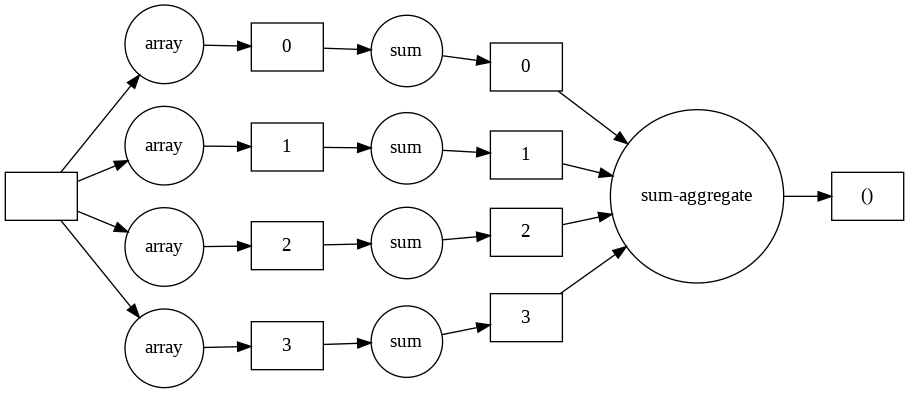

In [0]:
result.visualize(rankdir='LR')

## Timing array computations

In [0]:
!wget "https://github.com/wblakecannon/DataCamp/blob/master/05-importing-data-in-python-(part-1)/_datasets/LIGO_data.hdf5"

In [0]:
!wget https://www.gw-osc.org/archive/data/S5/814743552/H-H1_LOSC_4_V1-815411200-4096.hdf5

In [0]:

!cp H-H1_LOSC_4_V1-815411200-4096.hdf5 LIGO_data.hdf5

In [0]:
import h5py, time

In [0]:
# lets look at the keys of the file
data = h5py.File('./LIGO_data.hdf5', 'r')
type(data)

h5py._hl.files.File

In [0]:
for key in data.keys():
  print(key)

meta
quality
strain


In [0]:
with h5py.File('LIGO_data.hdf5', 'r') as dset:
  strain = dset['strain']['Strain'][:]

In [0]:
strain.shape

(16777216,)

In [0]:
strain_dask8 = da.from_array(strain, chunks=strain.shape[0]//8)

In [0]:
t_start = time.time()
mean8 = strain_dask8.mean().compute()
t_fin = time.time()

La diferencia entre los tiempos reescalada por 1000 es el tiempo en milisegundos que tardo en completar la operacion

In [0]:
t_transc = (t_fin-t_start)*1000
print('Tiempo transcurrido: {} ms'.format(t_transc))

Tiempo transcurrido: 73.51279258728027 ms


### Ejercicios

Para practicar!

In [0]:
# Call da.from_array():  energy_dask
energy_dask = da.from_array(energy, chunks=energy.shape[0]//4)

# Print energy_dask.chunks
print(energy_dask.chunks)

# Print Dask array average and then NumPy array average
print(energy_dask.mean().compute())
print(energy.mean())


# Import time
import time

# Call da.from_array() with arr: energy_dask4
energy_dask4 = da.from_array(energy, chunks=energy.shape[0]//4)

# Print the time to compute standard deviation
t_start = time.time()
std_4 = energy_dask4.std().compute()
t_end = time.time()
print((t_end - t_start) * 1.0e3)

## Arreglos multidimensionales



In [0]:
time_series = np.array([49,51,60,54,47,50,64,58,47,43,50,63,67,68,64,48,55,46,66,51,52])
np.savetxt('max_temps.csv', time_series.astype(int), fmt='%i')

In [0]:
time_series = np.loadtxt('max_temps.csv', dtype=np.int64) 

In [0]:
print(time_series.dtype)

int64


In [0]:
print(time_series.shape)

(21,)


In [0]:
print(time_series.ndim)

1


Cada entrada es la temperatura en und ia de la semana, lunes a domingo, la lista representa 21 dias

In [0]:
print(time_series) 

[49 51 60 54 47 50 64 58 47 43 50 63 67 68 64 48 55 46 66 51 52]


In [0]:
tabla = time_series.reshape((3,7)) # reorganiza la lista por renglones cada renglon es una semana

In [0]:
print(tabla)

[[49 51 60 54 47 50 64]
 [58 47 43 50 63 67 68]
 [64 48 55 46 66 51 52]]


In [0]:
time_series.reshape((7,3)) 

array([[49, 51, 60],
       [54, 47, 50],
       [64, 58, 47],
       [43, 50, 63],
       [67, 68, 64],
       [48, 55, 46],
       [66, 51, 52]])

In [0]:
time_series.reshape((7,3), order='F')

array([[49, 58, 64],
       [51, 47, 48],
       [60, 43, 55],
       [54, 50, 46],
       [47, 63, 66],
       [50, 67, 51],
       [64, 68, 52]])

In [0]:
tabla[0,4] # valor de semana 0 dia 4

47

In [0]:
tabla[1,2:5] # valores de semana 1 dias 2, 3 & 4 (excluye el 5)

array([43, 50, 63])

In [0]:
tabla[0::2, ::3] # valores de las semanas 0 & 2, dias 0, 3 & 6

array([[49, 54, 64],
       [64, 46, 52]])

In [0]:
tabla[0]

array([49, 51, 60, 54, 47, 50, 64])

In [0]:
tabla.mean() # promedio entre todos los elementos de la tabla

54.904761904761905

In [0]:
prom_diario = tabla.mean(axis=0)

In [0]:
prom_diario

array([57.        , 48.66666667, 52.66666667, 50.        , 58.66666667,
       56.        , 61.33333333])

In [0]:
prom_semanal = tabla.mean(axis=1)

In [0]:
prom_semanal

array([53.57142857, 56.57142857, 54.57142857])

In [0]:
tabla.mean(axis=(0,1))

54.904761904761905

In [0]:
tabla - prom_diario

array([[ -8.        ,   2.33333333,   7.33333333,   4.        ,
        -11.66666667,  -6.        ,   2.66666667],
       [  1.        ,  -1.66666667,  -9.66666667,   0.        ,
          4.33333333,  11.        ,   6.66666667],
       [  7.        ,  -0.66666667,   2.33333333,  -4.        ,
          7.33333333,  -5.        ,  -9.33333333]])

In [0]:
tabla - prom_semanal

ValueError: ignored

In [0]:
print(tabla.shape)
print(prom_diario.shape)
print(prom_semanal.shape)

(3, 7)
(7,)
(3,)


In [0]:
res = tabla - prom_semanal.reshape((3,1))

In [0]:
print(res)

[[ -4.57142857  -2.57142857   6.42857143   0.42857143  -6.57142857
   -3.57142857  10.42857143]
 [  1.42857143  -9.57142857 -13.57142857  -6.57142857   6.42857143
   10.42857143  11.42857143]
 [  9.42857143  -6.57142857   0.42857143  -8.57142857  11.42857143
   -3.57142857  -2.57142857]]


## Haciendo la conexion a Dask

In [0]:
data = np.genfromtxt('https://www1.ncdc.noaa.gov/pub/data/ccd-data/hghtmp15.dat', usecols=(2,3,4,5), skip_header=5, dtype=np.int64)

In [0]:
data.shape

(259, 4)

In [0]:
type(data)

numpy.ndarray

In [0]:
data_dask = da.from_array(data, chunks=(259,2))

In [0]:
res = data_dask.std(axis=0) # desviacion estandard por columnas

In [0]:
res.compute()

array([33.76117147, 18.49776124, 15.00331354, 10.15791446])